### 1.包导入

In [1]:
import gym
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

### 2.环境尝试

In [2]:
env = gym.make("CartPole-v1")
env.reset()
env.step(0)

/home/pp/anaconda3/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([ 0.04047491, -0.18096018,  0.01200202,  0.2754833 ], dtype=float32),
 1.0,
 False,
 False,
 {})

### 3.定义 Actor 网络

In [3]:
# 定义策略网络
class ActorNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = T.tensor(x, dtype=T.float32).to(self.device)
        layer1 = T.relu(self.fc1(x))
        layer2 = T.relu(self.fc2(layer1))
        p = T.softmax(self.fc3(layer2), dim=-1)
        return p

### 4. 定义 Critic 网络

In [4]:
class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = T.tensor(x, dtype=T.float32).to(self.device)
        layer1 = T.relu(self.fc1(x))
        layer2 = T.relu(self.fc2(layer1))
        value = self.fc3(layer2)
        return value


### 5.设置环境和超参数

In [5]:
# 设置环境
env = gym.make("CartPole-v1")
input_dim = env.observation_space.shape[0]  # 输入维度
hidden_dim = 512
output_dim = env.action_space.n  # 输出维度
# 设置超参数
batch_size = 64  # 设置每次更新的轨迹数量
gamma = 0.9  # 奖励折扣因子
avg_episode = 50
save_episode = 200
print_episode = 50
clip_norm = 100
continue_train = True
num_episodes = 5000
learning_rate = 1e-4
ppo_epochs = 10
gae_lambda = 0.95  # 通常取值在 0.9 - 0.99 范围内
clip_epsilon = 0.2
max_grad_norm = 0.5
critic_coef = 0.5

# 学习进度保存路径
actor_model_path = "./save/s13_actor_net.pth"
critic_model_path = "./save/s13_critic_net.pth"
avg_path = "./save/s13_avg_rewards.pth"

In [6]:
actor_net = ActorNetwork(input_dim, hidden_dim, output_dim)
critic_net = Critic(input_dim, hidden_dim)
actor_optimizer = optim.AdamW(actor_net.parameters(), lr=learning_rate)
critic_optimizer = optim.AdamW(critic_net.parameters(), lr=learning_rate)
avg_rewards = []

if continue_train:
    if os.path.exists(actor_model_path) and os.path.exists(critic_model_path) and os.path.exists(avg_path):
        actor_net.load_state_dict(T.load(actor_model_path))
        actor_net.to(actor_net.device)
        critic_net.load_state_dict(T.load(critic_model_path))
        critic_net.to(critic_net.device)
        with open(avg_path, "rb") as f:
            avg_rewards = pickle.load(f)
len(avg_rewards)

0

### 6.开始训练

In [7]:
record_rewards = []
for episode in range(1, num_episodes + 1):
    states, actions, rewards, dones, log_probs, values = [], [], [], [], [], []
    episode_reward = 0
    state = env.reset()[0]

    # 采集一批数据（Rollout）
    for _ in range(1000):  # 设置最大步长
        # Actor 网络输出动作概率
        probs = actor_net(state)
        m = Categorical(probs)
        action = m.sample()

        # 记录数据
        log_prob = m.log_prob(action)
        value = critic_net(state)

        next_state, reward, terminated, truncated, info = env.step(action.item())
        done = bool(terminated) or bool(truncated)

        # 保存数据用于批量更新
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        # log_probs.append(log_prob)
        # values.append(value)

        log_probs.append(log_prob.detach())
        values.append(value.detach())

        episode_reward += reward

        if done:
            break
        state = next_state

    # 计算优势估计 (Generalized Advantage Estimation)
    values = values + [critic_net(state)]  # 包括最后一个状态值
    advantages, returns = [], []
    gae = 0
    for t in reversed(range(len(rewards))):
        if dones[t]:
            delta = rewards[t] - values[t]
        else:
            delta = rewards[t] + gamma * values[t + 1] - values[t]
        gae = delta + gamma * gae_lambda * gae
        advantages.insert(0, gae)
        returns.insert(0, gae + values[t])

    # 转为张量
    states = T.tensor(states, dtype=T.float32).to(actor_net.device)
    actions = T.tensor(actions, dtype=T.long).to(actor_net.device)
    log_probs = T.stack(log_probs).to(actor_net.device)
    returns = T.tensor(returns, dtype=T.float32).to(actor_net.device)
    advantages = T.tensor(advantages, dtype=T.float32).to(actor_net.device)
    # 标准化优势
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # 多次小批量优化（Epoch Update）
    for _ in range(ppo_epochs):
        indices = T.randperm(len(states))  # 随机小批量
        for start in range(0, len(states), batch_size):
            end = start + batch_size
            minibatch_indices = indices[start:end]

            # 取小批量数据
            mb_states = states[minibatch_indices]
            mb_actions = actions[minibatch_indices]
            mb_log_probs = log_probs[minibatch_indices]
            mb_returns = returns[minibatch_indices]
            mb_advantages = advantages[minibatch_indices]

            # 重新计算策略比率和价值
            new_probs = actor_net(mb_states)
            new_m = Categorical(new_probs)
            new_log_probs = new_m.log_prob(mb_actions)
            ratio = T.exp(new_log_probs - mb_log_probs)  # 策略比率 r_t

            # 计算 Clipped Actor Loss
            surr1 = ratio * mb_advantages
            surr2 = T.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * mb_advantages
            actor_loss = -T.min(surr1, surr2).mean()

            # 计算 Critic Loss
            new_values = critic_net(mb_states).squeeze()
            critic_loss = F.mse_loss(new_values, mb_returns)

            # 总损失
            loss = actor_loss + critic_coef * critic_loss

            # 优化网络
            actor_optimizer.zero_grad()
            critic_optimizer.zero_grad()

            loss.backward()
            T.nn.utils.clip_grad_norm_(actor_net.parameters(), max_grad_norm)
            T.nn.utils.clip_grad_norm_(critic_net.parameters(), max_grad_norm)
            actor_optimizer.step()
            critic_optimizer.step()

    # 记录奖励
    record_rewards.append(episode_reward)

    # 输出训练进度
    if episode % avg_episode == 0:
        avg_reward = sum(record_rewards[-avg_episode:]) / avg_episode
        avg_rewards.append(avg_reward)
        if episode % print_episode == 0:
            print(
                f"Episode {episode}, Current Reward:{record_rewards[-1]}, Avg Reward: {avg_reward}"
            )
        if episode % save_episode == 0:
            print(f"to save model and avg_rewards {len(avg_rewards)}")
            T.save(actor_net.state_dict(), actor_model_path)
            T.save(critic_net.state_dict(), critic_model_path)
            with open(avg_path, "wb") as f:
                pickle.dump(avg_rewards, f)


/home/pp/anaconda3/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_64400/3923093059.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647327489/work/torch/csrc/utils/tensor_new.cpp:278.)
  states = T.tensor(states, dtype=T.float32).to(actor_net.device)
/tmp/ipykernel_64400/3983154946.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = T.tensor(x, dtype=T.float32).to(self.device)
/tmp/ipykernel_64400/1430761052.py:11: UserWarning: To copy cons

Episode 50, Current Reward:98.0, Avg Reward: 44.66
Episode 100, Current Reward:122.0, Avg Reward: 158.16


/tmp/ipykernel_64400/3923093059.py:87: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(new_values, mb_returns)


Episode 150, Current Reward:253.0, Avg Reward: 242.38
Episode 200, Current Reward:108.0, Avg Reward: 151.52
to save model and avg_rewards 4
Episode 250, Current Reward:125.0, Avg Reward: 166.14
Episode 300, Current Reward:471.0, Avg Reward: 297.66
Episode 350, Current Reward:500.0, Avg Reward: 400.46
Episode 400, Current Reward:420.0, Avg Reward: 376.04
to save model and avg_rewards 8
Episode 450, Current Reward:346.0, Avg Reward: 421.48
Episode 500, Current Reward:500.0, Avg Reward: 448.96
Episode 550, Current Reward:302.0, Avg Reward: 369.9
Episode 600, Current Reward:345.0, Avg Reward: 327.54
to save model and avg_rewards 12
Episode 650, Current Reward:389.0, Avg Reward: 359.94
Episode 700, Current Reward:500.0, Avg Reward: 457.82
Episode 750, Current Reward:341.0, Avg Reward: 401.08
Episode 800, Current Reward:445.0, Avg Reward: 408.4
to save model and avg_rewards 16
Episode 850, Current Reward:188.0, Avg Reward: 355.86
Episode 900, Current Reward:498.0, Avg Reward: 329.74
Episode 

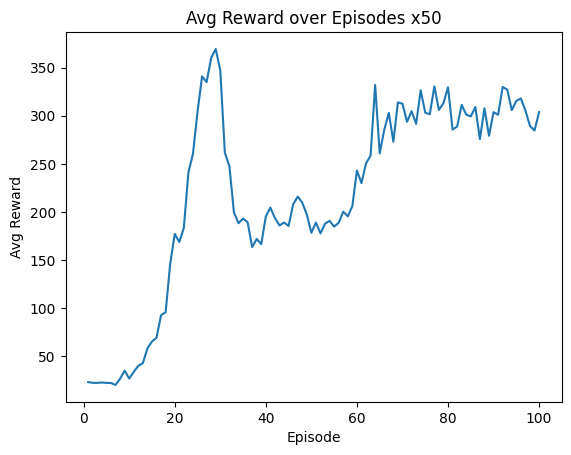

In [8]:
# 绘制得分变化图
plt.plot(range(1, len(avg_rewards) + 1), avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.title(f"Avg Reward over Episodes x{avg_episode}")
plt.show()